In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import dowhy
from dowhy import CausalModel
import dowhy.datasets

print("All packages imported successfully!")

All packages imported successfully!


## Generate synthethic data

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
N = 1000

# Generate synthetic features
income = np.random.normal(50000, 3000, N)  # Annual income

# Define a function to determine plus member status based on income
def determine_plus_member(income):
    probability = 1 / (1 + np.exp(-(income - 50000) / 5000))  # Logistic function for probability
    return np.random.binomial(1, probability)

# Generate binary feature for plus_member
plus_member = np.array([determine_plus_member(inc) for inc in income])

# Generate customer lifetime value (CLV) with some noise
clv = 0.08 * income + 500 * plus_member + np.random.normal(0, 2000, N)

# Create a DataFrame
data = pd.DataFrame({
    'income': income,
    'plus_member': plus_member,
    'clv': clv
})

data.head()

,income,plus_member,clv
0,51490.142459,1,4000.793243
1,49585.207096,0,2462.503757
2,51943.065614,0,4793.794270
3,54569.089569,1,7546.428058
4,49297.539876,0,193.458251


## Relationship between income and `plus_member = True` likelihood.

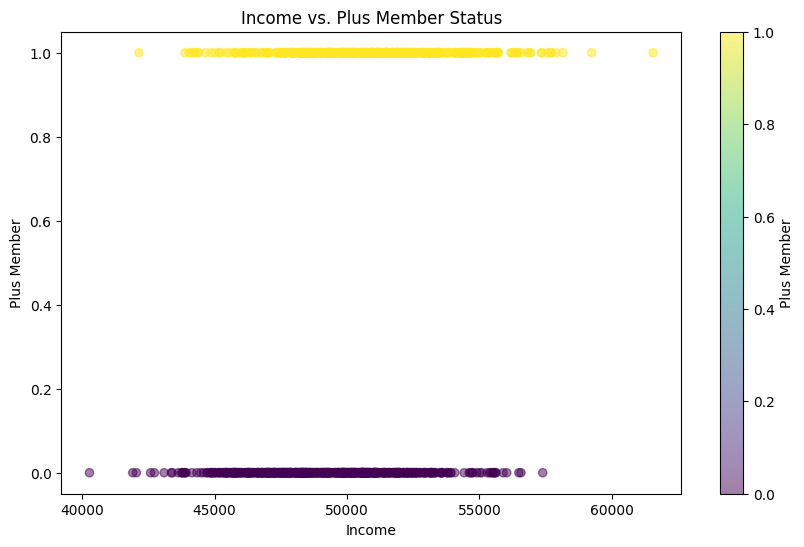

In [5]:
# Plot income vs. plus_member
plt.figure(figsize=(10, 6))
plt.scatter(data['income'], data['plus_member'], alpha=0.5, c=data['plus_member'], cmap='viridis')
plt.xlabel('Income')
plt.ylabel('Plus Member')
plt.title('Income vs. Plus Member Status')
plt.colorbar(label='Plus Member')
plt.show()


## Create a causal graph and a model

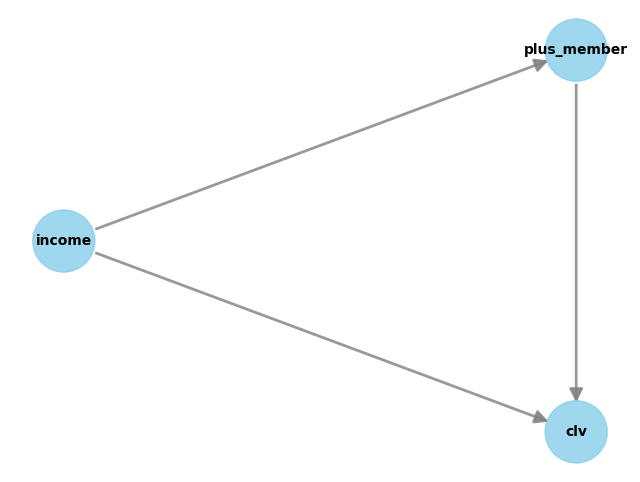

In [9]:
# Formalize causal graph using a Directed Acyclic Graph (DAG)
graph = """
digraph {
    income -> plus_member;
    income -> clv;
    plus_member -> clv;
}
"""

# Create a causal model instance
model = CausalModel(
    data=data,
    treatment='plus_member',
    outcome='clv',
    graph=graph
)

# Visualize the causal DAG
model.view_model()
plt.show()

## Identify the causal effect

In [10]:
# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
──────────────(E[clv|income])
d[plus_member]               
Estimand assumption 1, Unconfoundedness: If U→{plus_member} and U→clv then P(clv|plus_member,income,U) = P(clv|plus_member,income)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [12]:
# Estimate the causal effect using linear regression
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

# Display the effect estimate
print("Causal Estimate is ", estimate.value)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
──────────────(E[clv|income])
d[plus_member]               
Estimand assumption 1, Unconfoundedness: If U→{plus_member} and U→clv then P(clv|plus_member,income,U) = P(clv|plus_member,income)

## Realized estimand
b: clv~plus_member+income
Target units: ate

## Estimate
Mean value: 578.9491654365697

Causal Estimate is  578.9491654365697


/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [56]:
# Refute the estimate using a placebo test
refute_placebo = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute_placebo)

/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarni

Refute: Use a Placebo Treatment
Estimated effect:523.0045193280566
New effect:-13.214642792719483
p value:0.88



/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarni

In [13]:
# Refute the estimate using a data subset refuter
refute_subset = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print(refute_subset)

/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarni

Refute: Use a subset of data
Estimated effect:874.7774975956163
New effect:885.7635423189437
p value:0.98



/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/ekinderdiyok/Documents/projects/causal-inference/.conda/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarni